# Spectroscopy Concept

In this note, I will show you how the spectroscopic data look like, and then make a simulation code to demonstrate how a line fitting is done. Since preprocessing and sky estimation is not the main topic, I will sometimes ignore detailed issues but just give big pictures. One very good summary of how spectroscopic data reduction is done is given in the [lecture note by C. Harrison given at Durham University](http://astro.dur.ac.uk/~knpv27/pg_dr_course/PG_DR_spectra.pdf).

The following image shows an example of spectroscopic data. In the middle, there is the spectrum of the target. As you expect, the horizontal axis is the wavelength direction (depending on the instrument, but I described the wavelength increases towards right). But since the slit has finite width, much larger than the point source we are observing, there are sky spectra towards up/down direction. This vertical direction is called the spatial direction.

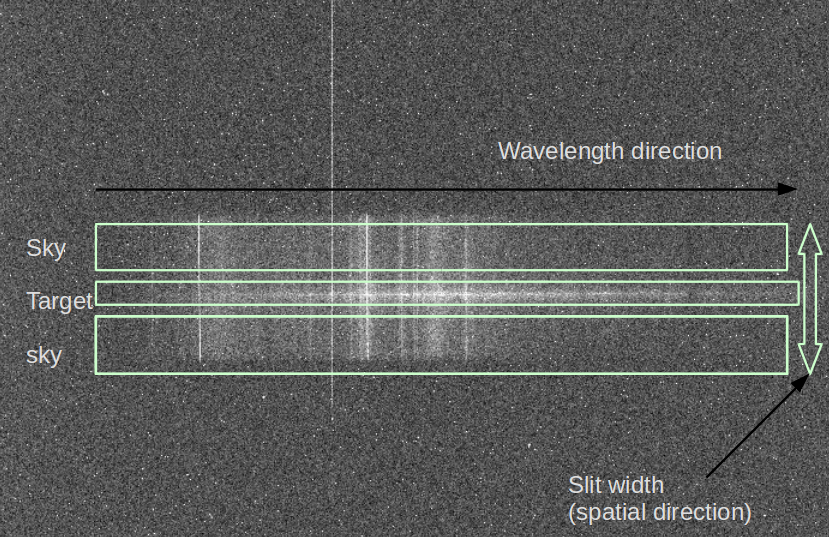

In [4]:
from IPython.display import Image

Image(filename='images/spec_concept.png', width='500')

In spectroscopy, basically we do
* Preprocessing
  * Basic preprocessing (bias, dark subtraction and flat fielding)
  * Cosmic-ray (CR) rejection (if necessary)
  * Additional preprocessing (crop overscan, distortion correction, combine many chips if needed, etc)
* Wavelength Identification (Transformation)
  * Use "sky" region, lamps, dusk, etc.
  * "``x = 1`` is ``lambda = 500 nm``, ``x = 2`` is ``lambda = 502nm``, ..."
* Sky subtraction
  * Use "sky" region
* Dither Stack (if necessary)
* Flux Calibration
  * Use spectroscopic standard star.
  * For standard star, we usually use lamp for wavelength identification (WHY?)
  * "``count = 1`` at ``lambda = 500 nm`` corresponds to 1.8 Jy, ``count = 1`` at ``lambda = 502 nm`` corresponds to 1.2 Jy, ..."
* Further correction
  * Atmospheric extinction correction
  * Terrestrial relative velocity correction
  * ...
  

## Simulating Observed Data



In [2]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.modeling.functional_models import Gaussian1D
from scipy.optimize import curve_fit
from astropy.modeling.fitting import LevMarLSQFitter

After importing the above packages, you are now ready to generate a fake spectroscopic data. I will generate a data by using the following information:
* $ \lambda \in [500, 750) $ nm
* Resolution $ \Delta \lambda = 2.5 $ nm (constant)
* ``gain = 2.5`` electrons/ADU
* ``readout_noise = 10`` electrons
* We expect a line to have Gaussian shape with central wavelength 600 nm, width 20 nm (1-sigma is 10 nm), and the amplitude 50 electrons for the given exposure time.
  * A more realistic model will be Voigt profile. See [``astropy.modeling.functional_models.Voigt1D``](http://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Voigt1D.html#astropy.modeling.functional_models.Voigt1D)
* Sky is smooth Gaussian (i.i.d. with $ \sim N(100, 1^2) $) plus a 3rd order function of wavelength.

First let's generate the fake data:

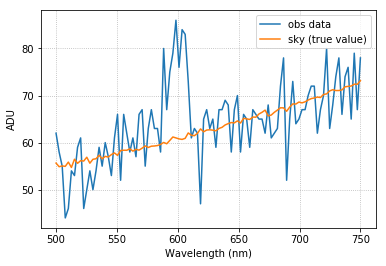

In [4]:
def fake_3rd(x, a=1.e-7, b=4.e-5, c=1.e-2, d=10):
    return a * x**3 + b * x**2 + c * x + d

def fake_e2ADU(signal_electron, gain=1.0):
    sig_ADU = signal_electron / gain
    sig_ADU_int = np.around(sig_ADU).astype(int)
    return sig_ADU_int

np.random.seed(1)

#==============================================================================
# What we know a priori from instrument spec:
nbins     = 100
lambda_min= 500
lambda_max= 750
gain      = 2.5 # electrons/ADU
ronoise   = 10  # electrons
lambdas   = np.linspace(lambda_min, lambda_max, nbins)

#==============================================================================
# Hypothesis
# Our null hypothesis for the line
line_amp  = 50   # amplitude in electrons
line_cent = 600  # central wavelength in nm
line_width= 10   # line width in nm
line_prof = Gaussian1D(amplitude=line_amp, mean=line_cent, stddev=line_width)
#==============================================================================
# Fake sky:
# sky related parameters should have been obtained from sky pixels in spec data.
# In this example, randomly generate them.
# We can sky values from, e.g., 7 pixels up/down from the line.
# sky_level: mean sky pixel value at lambda in *electrons* unit
#         ( iid ~ N(100, 1^2) + 3rd order noise)

sky_level_e = ( np.random.normal(loc=100, scale=1, size=nbins) # random gaussian noise
               + fake_3rd(lambdas)                             # 3rd order noise
              )

#==============================================================================
# Then generate fake data and convert to electron unit from ADU
# obs: # of *electrons* at each pixel.
obs = ( np.random.poisson(lam=sky_level_e)           # sky from real sky value
       + np.random.normal(scale=ronoise, size=nbins) # ronoise
       + line_prof(lambdas)                          # line profile
        )

obs_ADU = fake_e2ADU(obs, gain=gain)

plt.plot(lambdas, obs_ADU, label="obs data")
plt.plot(lambdas, sky_level_e/gain, label="sky (true value)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("ADU")
plt.legend()
plt.grid(ls=":")
plt.show()

This is a simulation of the 1-D line plot, e.g., at the central bright horizontal line of the first image.

Let's now subtract the sky. To simulate the real data reduction, I first will generate the "Sky" region. Then fit a 3rd order function to that sky data. The raw and sky data will be converted to electron unit and error will be used to fit a Gaussian profile.

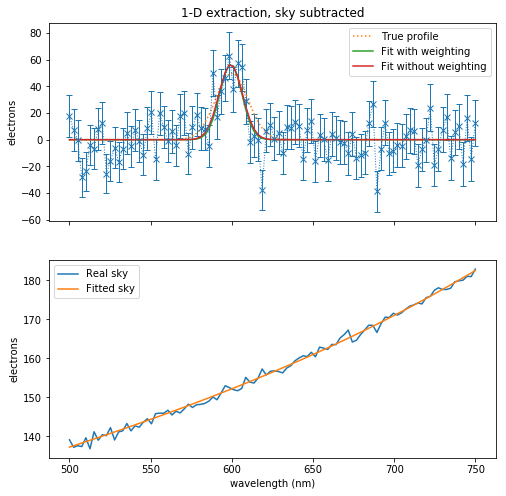

fit with weighting
--------------------------------------------------------------------------------
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
      amplitude        mean         stddev   
    ------------- ------------- -------------
    56.6903141203 599.364236991 6.81830068632


fit without weighting
--------------------------------------------------------------------------------
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
      amplitude        mean         stddev   
    ------------- ------------- -------------
    56.3854244005 599.322417536 7.25865308423


In [5]:
# Consider the ``obs_ADU`` as if it is the real data we obtained.
# I did non include the error term due to sky estimation, which is not correct!
# If you want to take this into account, you can use bootstrap, etc

# obs_e: observed values converted to electrons
# obs_err: observation error bar in electrons

obs_e   = obs_ADU * gain  # This of course should be equal to ``obs``
obs_err = np.sqrt( obs_e + ronoise**2 ) # Poisson + ronoise

# Say we obtained sky in ADU from sky pixels at each wavelength bin.
# That will be in ADU (``sky_ADU``) and we will fit the sky values to
# a 3rd order function.

# generate sky again to mimic sky pixels:
sky_est_e = ( np.random.normal(loc=100, scale=1, size=nbins) # random gaussian noise
             + fake_3rd(lambdas)                           # 3rd order noise
            )

# Fit the sky pixel values with 3rd order function and subtract it from obs:
sigmas = np.sqrt( sky_est_e + ronoise**2) # in e-
popt, pcov = curve_fit(fake_3rd, xdata=lambdas, ydata=sky_est_e,
                       sigma=sigmas, absolute_sigma=True)
# Be careful that ``absolute_sigma`` is ``False`` by default!!

obs_skysub_e = obs_e - fake_3rd(lambdas, *popt)

fitter = LevMarLSQFitter()
g_init = Gaussian1D(amplitude=line_amp, mean=line_cent, stddev=line_width)
g_fit = fitter(g_init, lambdas, obs_skysub_e, weights=1/obs_err**2)
g_fit_noweight = fitter(g_init, lambdas, obs_skysub_e)
# The format for weights is different from some other cases. We need 1/err**2 here.

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,8))
axs[0].errorbar(lambdas, obs_skysub_e, yerr=obs_err, capsize=3, lw=1, marker='x', ls=':')
axs[0].plot(lambdas, line_prof(lambdas), ls=':', label="True profile")
axs[0].plot(lambdas, g_fit(lambdas), label="Fit with weighting")
axs[0].plot(lambdas, g_fit_noweight(lambdas), label="Fit without weighting")
axs[1].plot(lambdas, sky_level_e, label="Real sky")
axs[1].plot(lambdas, fake_3rd(lambdas, *popt), label="Fitted sky")
axs[0].set_ylabel("electrons")
axs[1].set_ylabel("electrons")
axs[1].set_xlabel("wavelength (nm)")
axs[0].set_title("1-D extraction, sky subtracted")
axs[0].legend()
axs[1].legend()
plt.show()

print("fit with weighting")
print("-"*80)
print(g_fit)
print("\n"+"="*80+"\n")
print("fit without weighting")
print("-"*80)
print(g_fit_noweight)

In the first figure, the fitted Gaussians with the original Gaussian profile is given. You can see that the amplitude is systematically over estimated and line width (``2 * stddev``) is underestimated. The center (``mean``) is fitted to be slightly blue-shifted by $ z \sim 1/600 $. The error for these three parameters will be obtained if you do bootstrapping (resampling technique). The resulting errors will be decreased if you make more observations.

The second figure shows the justification of sky fitting. In reality, the sky may not be fitted this well, since you may fit 3rd order while the actual sky is 10th order, etc.

* **TIP**: Gaussian fitting is very vernerable to be captured in a local minimum. As in any astronomical tools (including IRAF), it is necessary to give proper ansatz for center and width. If not, it will fit to strange features, such as sky noise at around 520 nm in our case.

## Data Analysis

Let's now regard the above data ``obs_skysub_e`` as a given data, and do a realistic analysis. The big question is 

> **How likely is that the peak is an actual line(s), not due to random noise?**

To test this, let's set up hypotheses: 
* The null hypothesis ($H_0$): There is no line
* The alternative hypothesis ($H_1$): There is a line

Note that we haven't specified the properties of the line (amplitude, width, etc) yet. Then

1. We have to check which hypothesis is more likely.
2. If $H_0$ is more likely, we conclude that "we can deny the existence of line in this data with certainty of xxx".
3. If $H_1$ is more likely, we have to find the line properties (amplitude, width, etc) in the form of $ a \pm da $.

The first is called **Model Selection** and the third is called **Parameter Estimation**. Model selection deals with discrete case (finite number of different hypotheses), while parameter estimation usually deals with continuous case.

### Model Selection
Bayes' theorem states 

$$ P(H | D, I) = \frac{P(H|I) \times P(D|H, I)}{P(D|I)} ~.$$

Here, $H$, $D$, and $I$ are the hypothesis, data, and prior information, respectively. The **posterior** $P(H|D, I)$ is understood as "the probability that the hypothesis is true, given the data equals to $D$ and we have prior information $I$." The **prior** $P(H|I)$ can be quite subjective, since it means "the probability that the hypothesis is true." We take either uniform prior or Jeffrey's prior. The denominator, $P(D | I)  \equiv \int P(D | H, I) P(H|I) dH$ is understood as the normalization constant for the posterior. Usually it is thus simply put as 

$$ P(H | D, I) \propto P(H|I) \times P(D|H, I) ~.$$

The term $P(D|H, I)$ is called the **likelihood**, and this is what we have calculated during our high school course works: 

*Given the hypothesis that a person has possibility 0.5 to win a game, what is the probability for her to win 3 games in a row?*

In this case, the hypothesis is $H: \mathrm{"}p=0.5\mathrm{"}$, and the data $D = \mathrm{"win~3~in~a~row"}$. The prior knowledge is that "the game rule does not change", "the person doesn't use faul measures to make the possibility to change over time", etc, which are just trivial assumptions. In real scientific problems, $I$ can be something like "the fundamental physical laws do not change over time", "this galaxy is spiral for sure (if you're working on rotational curves of S galaxies, you may assume your samples are definitely S, not E or Irr)", etc.

The model selection is done based on the **Bayes' ratio** or the **odds ratio**:

$$ R := \frac{P(H_1 | D, I)}{P(H_0 | D, I)} $$

If $ R > 1 $, we select $H_1$ over $H_0$ and vice versa. If $R=1$, we can't give any conclusion. Substituting Bayes' thm, $P(D|I)$ cancels out and

$$ R = \frac{P(H_1|I)}{P(H_1|I)} \times \frac{P(D|H_1, I)}{P(D|H_0, I)} = ratio(prior) \times ratio(likelihood)~. $$

Equivalently, we can use $\log_e R $ and compare it with 0. This is because we frequently get extremely large or small $R$ values (e.g., $10^{-40}$), which is inappropriate for some computer programming.

#### Prior Selection
There are two major priors: uniform and Jeffrey's prior.

**Uniform prior** assumes uniform probability for the model within reasonable range. If we take this for our case, any model which has amplitude from 25 to 75 is equally likely. The lower/upper bounds can be set by the scientist subjectively. As far as the range is sufficiently large, the final result will not be affected much. Quantitatively, if $A$ is the amplitude, $ P(A|I) = 1/(75 - 25) =1/50$ for all $A \in [25, 75]$. 

**Jeffrey's prior** assumes the probability proportional to the inverse of the parameter. That is, if the parameter is small, we give more weight to it; this is similar to the information theory which gives higher weight if a data is "unlikely". For this reason, we usually use Jeffrey's prior for standard deviation estimation. Quantitatively, it is $ P(A|I) = \frac{1}{A \log_e(75/25)}$. This is understood as the uniform prior of the log of $A$: $P(\log_e A| I) d(\log_e A) = \frac{d(\log_e A)}{\log_e A_{max} - \log_e A_{min}} $ $\rightarrow P(\log_e A| I) = \frac{1}{A \log_e (A_{max}/A_{min})}$ .

Since Jeffrey's prior is non-sensical when we include model of $A=0$, a **modified Jeffrey's prior** is also used: $ P(A|I) = \frac{1}{A+A_0} \times \frac{1}{\log_e \frac{A_0+A_{max}}{A_0+A_{min}}} $. This is nothing but a parallel shift of parameters by a certain constant $A_0$. $A_0$ can be taken as a noise level, such as readout noise in our case.

#### Likelihood Calculation
Assume all data values are independent and follows an identical distribution (i.i.d. assumption). The "identical distribution" in our case can reasonably be assumed as Gaussian distribution with zero mean and stdev of readout noise ($\sigma_r$). We have Poissonian noise term and sky estimation noise term (the latter is not calculated above), so you may use this pixel-wise error values. Applying the product rule to independent measurements,

$$ P(D|H, I) = P(D_1, \cdots , D_N | H, I) = P(D_1 | H, I) \times \cdots \times P(D_N | H, I) ~. $$

Under $H_0$, $P(D_i | H_0, I) $ is the probability to measure $D_i$ electrons when there is only the readout noise $\sigma_r$ (no actual line). This is calculated by normal distribution: $P(D_i | H_0, I) = \frac{1}{\sqrt{2 \pi} \sigma_r^2} \exp{ \left ( -\frac{(D_i - 0)^2}{2 \sigma_r^2} \right )} $. Then

$$ P(D|H_0, I) = \left ( \frac{1}{\sqrt{2 \pi} \sigma_r} \right)^N \times \exp{ \left ( \sum_{i=1}^{N} -\frac{(D_i - 0)^2}{2 \sigma_r^2} \right )}$$

so

$$ \log_e P(D|H_0, I) = -\frac{N}{2} \log_e (2 \pi \sigma_r^2) - \sum_{i=1}^{N} \frac{(D_i - 0)^2}{2 \sigma_r^2}  $$

For $H_1$, we can just change the zero mean to the Gaussian line profile: something like ``G(x=i)``. At any ``i``-th bin, we know expected value $E_i$ from the Gaussian profile with input amplitude, center, and width. Thus

$$ \log_e P(D|H_1, I) = -\frac{N}{2} \log_e (2 \pi \sigma_r^2) - \sum_{i=1}^{N} \frac{(D_i - E_i)^2}{2 \sigma_r^2}  $$

$E_i$ will be nearly zero outside of ``mean +- 3 * sigma``.

#### Calculation for Model Selection
Now let's do the real calculation to compare $H_0$ and $H_1$. By $H_1$, we did not specify the amplitude ($A$), central wavelength($\lambda_0$), and width ($w$), we have to marginalize the probabilities to calculate the likelihood. In the previous equation, $E_i$ can be understood as a function of given paramters: $E_i (A, \lambda_0, w)$.

Let me assume uniform prior to all three paramters with domains $A \in [1, 30]$, $\lambda_0 \in [590, 610]$, and $w \in [5, 15]$, and thus $P(A|I) dA = (1/29) dA$, etc. Assuming all paramters are independent, we can use product rule and

$$ P(D|H_1, I) = \int_{5}^{15} \int_{590}^{610} \int_{25}^{75} 
                P(D | A, \lambda_0, w, I)~P(A|I)~P(\lambda_0|I)~P(w|I) ~dA~d\lambda_0~dw ~, $$

or

$$ \log_e P(D|H_1, I) = - \log_e (10000) + \log_e \left [ \int_{5}^{15} \int_{590}^{610} \int_{25}^{75} 
                P(D | A, \lambda_0, w, I) ~dA~d\lambda_0~dw \right ] ~, $$

with 
$$ P(D|A, \lambda_0, w, I) = \left ( \frac{1}{\sqrt{2 \pi} \sigma_r} \right )^N 
                \times \exp \left [ -\sum_{i=1}^{N} \frac{(D_i - E_i(A, \lambda_0, w))^2}{2 \sigma_r^2} \right ] ~. $$


Since $H_0$ has no more parameters, we just use the previous $\log_e P(D|H_0, I)$ formula.

In [12]:
def likelihood_gaussian(x, data, error, amplitude, mean, stddev):
#    if len(error) != 1:
#        raise ValueError('One and only one error should be given.')
        
    N_data = len(data)
    model = Gaussian1D(amplitude=amplitude, mean=mean, stddev=stddev)
    const_term = (np.sqrt(2 * np.pi) * error)**(-N_data)
    chi_term = -(data - model(x))**2 / (2 * error**2)
    chi_sum  = np.sum(chi_term)
    return const_term * np.exp(chi_sum)

arr_A = np.arange(25, 75, 1)
arr_L = np.arange(590, 610.1, 0.5)
arr_w = np.arange(5, 15.1, 0.5)
likelihoods = np.zeros((len(arr_A), len(arr_L), len(arr_w)))

for i in range(len(arr_A)):
    for j in range(len(arr_L)):
        for k in range(len(arr_w)):
            likelihoods[i, j, k] = likelihood_gaussian(lambdas, 
                                                       obs_skysub_e, 
                                                       ronoise,
                                                       arr_A[i],
                                                       arr_L[j],
                                                       arr_w[k])

loglikelihood_H1 = -np.log(10000) + np.log(likelihoods.sum())
loglikelihood_H0 = (- len(obs_skysub_e) * np.log(np.sqrt(2 * np.pi * ronoise**2))
                    - (obs_skysub_e**2/(2*ronoise**2)).sum())
R = loglikelihood_H1 - loglikelihood_H0
print('R = {:.2f}'.format(R))

R = 76.97


Since $R$ is much larger than 1, we prefer $H_1$ against $H_0$. From now, thus, I will assume that there is a line.

If I finechop the grid of parameters to 0.2, the Bayes' ratio (odds ratio) was 80.41, which is still much larger than 1.

* **TIP**: How about the case when you think there are 2+ lines? In that case, more parameters will be added to the calculation, and the calculation time will grow exponentially. If you can calculate everything as we did in the above code, that is THE BEST way. We may, however, find the maximum likelihood parameter sets quickly by sacrificing error calculation (not calculate likelihood at everywhere but use algorithm to find minimum). The efficient way to choose a model then, (under Gaussian noise assumption) is to use **Bayesian Information Criterion (BIC)**. It only takes minimum chi square and number of parameters in the competing models, and mathematically proven to be THE most powerful criterion for model selection under some assumptions. We will not cover that since it's out of our scope.

* **TIP**: When the signal to noise ratio is low (high noise level), the selection of prior affects the model selection critically (e.g., $R=0.9$ for uniform but $R=11$ for Jefferey's). So it's better to use various priors and test whether the result is robust against prior selection. This is out of our scope.

### Parameter Estimation
Now that we know there IS a line, what is the best fit values of parameters ($A$, $\lambda_0$, and $w$) and their corresponding errors? The most intuitive and mathematically valid way is to marginalize the probability. I want to normalize each marginalized pdf to sum to 1.

* **TIP**: If you have used chi square statistic, you can use the fact that $ P \propto e^{-\chi^2/2} $. Define $ \bar{P} =  e^{-\chi^2/2}$.  Then the normalization constant will be $ A = \sum_{parameters} \bar{P} $, i.e., you can use $P = \bar{P}/A$ as the normalized probability values.



MLE of Amplitude (e): 55.00
MLE of Center (nm): 599.50
MLE of Width (nm): 7.50


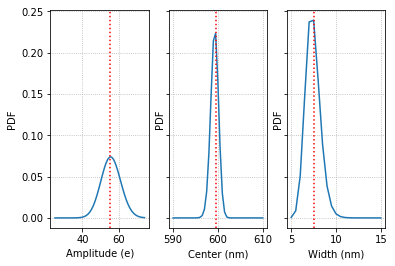

In [17]:
def pplot(axes, x, y, xlabel, ylabel):
    x_max = x[np.argmax(y)]
    axes.plot(x, y)
    axes.grid(ls=':')
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.axvline(x_max, ls=':', color='r')
    print('MLE of {}: {:.2f}'.format(xlabel, x_max))    

normaln = likelihoods.sum()
pdf_A = likelihoods.sum(axis=(1,2))/normaln
pdf_L = likelihoods.sum(axis=(0,2))/normaln
pdf_w = likelihoods.sum(axis=(0,1))/normaln

fig, axs = plt.subplots(1, 3, sharey=True)
pplot(axs[0], arr_A, pdf_A, xlabel='Amplitude (e)', ylabel='PDF')
pplot(axs[1], arr_L, pdf_L, xlabel='Center (nm)', ylabel='PDF')
pplot(axs[2], arr_w, pdf_w, xlabel='Width (nm)', ylabel='PDF')
plt.show()

If you want to quantitatively estimate the error, you may fit Gaussian to the pdf (not recommended). The recommended way is to find the minimum width from the most likely value (MLE = Maximum Likelihood Estimator) such that the integrated area is 0.67 (1-sigma). It may be assymetric.

Also if you want a publication quality plot, you have to tune the searching parameter for this case: the width seem to have possibility of lower value ($< 5$ nm). You have to change the searching grid to include $w <5$ domain.